In [18]:
# Imports and setup
import os, json, re, random
from collections import Counter, defaultdict
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print(f"Device: {device}")

Device: cuda


In [ ]:
# Config: Kaggle paths and hyperparameters
DATA_ROOT = "/kaggle/input/coco-2017-dataset/coco2017"
TRAIN_IMAGES_DIR = os.path.join(DATA_ROOT, "train2017")
CAPTIONS_PATH = os.path.join(DATA_ROOT, "annotations", "captions_train2017.json")

# Training hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-4

# Captioning hyperparameters
EMBED_DIM = 256
HIDDEN_DIM = 512
NUM_LSTM_LAYERS = 1
MAX_SEQ_LEN = 20
MIN_FREQ = 5

# limit number of samples for quick runs (set to None for all)
MAX_SAMPLES = None

# Defined action classes
ACTION_CLASSES = ["walking", "running", "sitting", "standing", "riding", "playing", "eating"]

# Verify expected paths exist
print("Images dir exists:", os.path.isdir(TRAIN_IMAGES_DIR))
print("Captions file exists:", os.path.isfile(CAPTIONS_PATH))

Images dir exists: True
Captions file exists: True


In [ ]:
# Action verb mapping and tokenizer
# Simple rule-based verb mapping 
VERB_TO_ACTION = {
    "walk": "walking", "walking": "walking", "walks": "walking", "walked": "walking",
    "run": "running", "running": "running", "runs": "running", "ran": "running",
    "sit": "sitting", "sitting": "sitting", "sits": "sitting", "sat": "sitting",
    "stand": "standing", "standing": "standing", "stands": "standing", "stood": "standing",
    "ride": "riding", "riding": "riding", "rides": "riding", "rode": "riding",
    "play": "playing", "playing": "playing", "plays": "playing", "played": "playing",
    "eat": "eating", "eating": "eating", "eats": "eating", "ate": "eating"
}

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    tokens = [t for t in text.split() if t]
    return tokens

def extract_action(tokens):
    for t in tokens:
        if t in VERB_TO_ACTION:
            return VERB_TO_ACTION[t]
    return None

action_to_idx = {a: i for i, a in enumerate(ACTION_CLASSES)}
idx_to_action = {i: a for a, i in action_to_idx.items()}
print("Action to index:", action_to_idx)

Action to index: {'walking': 0, 'running': 1, 'sitting': 2, 'standing': 3, 'riding': 4, 'playing': 5, 'eating': 6}


In [21]:
# Parse COCO captions and filter images by defined actions
assert os.path.isfile(CAPTIONS_PATH), "captions_train2017.json not found. Check DATA_ROOT."
print("Loading COCO captions...")
with open(CAPTIONS_PATH, "r", encoding="utf-8") as f:
    caps_data = json.load(f)

id_to_filename = {img["id"]: img["file_name"] for img in caps_data["images"]}
id_to_caps = defaultdict(list)
for ann in caps_data["annotations"]:
    id_to_caps[ann["image_id"]].append(ann["caption"])

items = []
class_counts = Counter()
for image_id, caps in tqdm(id_to_caps.items(), total=len(id_to_caps), desc="Filtering images"):
    fn = id_to_filename.get(image_id)
    if not fn:
        continue
    img_path = os.path.join(TRAIN_IMAGES_DIR, fn)
    if not os.path.isfile(img_path):
        continue
    chosen = None
    chosen_action = None
    for c in caps:
        toks = tokenize(c)
        act = extract_action(toks)
        if act is not None:
            chosen = toks
            chosen_action = act
            break
    if chosen is None:
        continue
    items.append({"image_path": img_path, "caption_tokens": chosen, "action": chosen_action})
    class_counts[chosen_action] += 1

if MAX_SAMPLES is not None:
    items = items[:MAX_SAMPLES]

print(f"Filtered samples: {len(items)}")
print("Class distribution:", dict(class_counts))
assert len(items) > 0, "No samples found with the defined actions."

Loading COCO captions...


Filtering images:   0%|          | 0/118287 [00:00<?, ?it/s]

Filtered samples: 80449
Class distribution: {'sitting': 31978, 'riding': 9308, 'eating': 2872, 'walking': 6358, 'standing': 22414, 'playing': 6226, 'running': 1293}


In [22]:
# Vocabulary building
class Vocabulary:
    def __init__(self, min_freq=1):
        self.min_freq = min_freq
        self.specials = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]
        self.stoi = {}
        self.itos = []
        self.pad_token = "<PAD>"
        self.sos_token = "<SOS>"
        self.eos_token = "<EOS>"
        self.unk_token = "<UNK>"

    def build(self, token_lists):
        freq = Counter()
        for toks in token_lists:
            freq.update(toks)
        self.itos = list(self.specials)
        for tok, c in freq.items():
            if c >= self.min_freq:
                self.itos.append(tok)
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}
        self.pad_id = self.stoi[self.pad_token]
        self.sos_id = self.stoi[self.sos_token]
        self.eos_id = self.stoi[self.eos_token]
        self.unk_id = self.stoi[self.unk_token]

    def numericalize(self, tokens):
        return [self.stoi.get(t, self.unk_id) for t in tokens]

    def encode(self, tokens, max_len):
        inp = [self.sos_token] + tokens
        tgt = tokens + [self.eos_token]
        in_ids = self.numericalize(inp)
        tg_ids = self.numericalize(tgt)
        # pad/truncate
        in_ids = (in_ids + [self.pad_id] * max_len)[:max_len]
        tg_ids = (tg_ids + [self.pad_id] * max_len)[:max_len]
        return in_ids, tg_ids

token_lists = [it["caption_tokens"] for it in items]
vocab = Vocabulary(min_freq=MIN_FREQ)
vocab.build(token_lists)
VOCAB_SIZE = len(vocab.itos)
print("Vocab size:", VOCAB_SIZE)
print("PAD id:", vocab.pad_id, "SOS id:", vocab.sos_id, "EOS id:", vocab.eos_id, "UNK id:", vocab.unk_id)

Vocab size: 3257
PAD id: 0 SOS id: 1 EOS id: 2 UNK id: 3


In [25]:
# PyTorch Dataset
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

class COCOActionCaptionDataset(Dataset):
    def __init__(self, items, vocab, transform, action_to_idx, max_len):
        self.items = items
        self.vocab = vocab
        self.transform = transform
        self.action_to_idx = action_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        img = Image.open(it["image_path"]).convert("RGB")
        img_t = self.transform(img)
        action_idx = self.action_to_idx[it["action"]]
        in_ids, tg_ids = self.vocab.encode(it["caption_tokens"], self.max_len)
        return (
            img_t,
            torch.tensor(action_idx, dtype=torch.long),
            torch.tensor(in_ids, dtype=torch.long),
            torch.tensor(tg_ids, dtype=torch.long),
        )

dataset = COCOActionCaptionDataset(items, vocab, transform, action_to_idx, MAX_SEQ_LEN)
print("Dataset size:", len(dataset))
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

Dataset size: 80449


In [26]:
# Model: Shared ResNet-50 backbone + Action head + Captioning LSTM
class SharedResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        try:
            resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        except Exception:
            resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # up to avgpool
        self.out_dim = 2048
    def forward(self, x):
        f = self.backbone(x)  # (N, 2048, 1, 1)
        return f.view(f.size(0), -1)

class ActionHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.net(x)

class CaptionDecoder(nn.Module):
    def __init__(self, in_dim, vocab_size, embed_dim, hidden_dim, num_layers, pad_id):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.to_h0 = nn.Linear(in_dim, hidden_dim)
        self.to_c0 = nn.Linear(in_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, vocab_size)
        self.num_layers = num_layers
    def forward(self, img_feat, captions_in):
        emb = self.embed(captions_in)
        h0 = torch.tanh(self.to_h0(img_feat))
        c0 = torch.tanh(self.to_c0(img_feat))
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = c0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        out_seq, _ = self.lstm(emb, (h0, c0))
        logits = self.out(out_seq)  # (N, T, V)
        return logits

class MultiTaskModel(nn.Module):
    def __init__(self, num_actions, vocab_size, embed_dim, hidden_dim, num_layers, pad_id):
        super().__init__()
        self.cnn = SharedResNet50()
        self.action_head = ActionHead(self.cnn.out_dim, num_actions)
        self.caption_head = CaptionDecoder(self.cnn.out_dim, vocab_size, embed_dim, hidden_dim, num_layers, pad_id)
    def forward(self, images, captions_in):
        img_feat = self.cnn(images)
        action_logits = self.action_head(img_feat)
        caption_logits = self.caption_head(img_feat, captions_in)
        return action_logits, caption_logits

model = MultiTaskModel(num_actions=len(ACTION_CLASSES), vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_layers=NUM_LSTM_LAYERS, pad_id=vocab.pad_id)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)
print(model.__class__.__name__, "initialized")

Using 2 GPUs
DataParallel initialized


In [27]:
# Training loop with combined loss
action_criterion = nn.CrossEntropyLoss()
caption_criterion = nn.CrossEntropyLoss(ignore_index=vocab.pad_id)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Lists to store metrics for plotting
history = {
    "total_loss": [],
    "action_loss": [],
    "caption_loss": [],
    "action_acc": []
}

def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0
    total_action = 0.0
    total_caption = 0.0
    total_correct = 0
    total_samples = 0
    n_batches = 0
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for imgs, act_targets, cap_in, cap_tg in pbar:
        imgs = imgs.to(device, non_blocking=True)
        act_targets = act_targets.to(device, non_blocking=True)
        cap_in = cap_in.to(device, non_blocking=True)
        cap_tg = cap_tg.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        act_logits, cap_logits = model(imgs, cap_in)
        
        # Calculate losses
        act_loss = action_criterion(act_logits, act_targets)
        V = cap_logits.size(-1)
        cap_loss = caption_criterion(cap_logits.view(-1, V), cap_tg.view(-1))
        loss = 0.4 * act_loss + 0.6 * cap_loss
        
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        total_action += act_loss.item()
        total_caption += cap_loss.item()
        
        # Accuracy (Action)
        preds = torch.argmax(act_logits, dim=1)
        total_correct += (preds == act_targets).sum().item()
        total_samples += act_targets.size(0)
        
        n_batches += 1
        current_mean_acc = total_correct / total_samples
        pbar.set_postfix({
            "total": f"{loss.item():.4f}", 
            "act": f"{act_loss.item():.4f}", 
            "cap": f"{cap_loss.item():.4f}",
            "acc": f"{current_mean_acc:.4f}"
        })
        
    avg_loss = total_loss / max(1, n_batches)
    avg_action = total_action / max(1, n_batches)
    avg_caption = total_caption / max(1, n_batches)
    avg_acc = total_correct / max(1, total_samples)
    
    print(f"Epoch {epoch}: Loss {avg_loss:.4f} | Action {avg_action:.4f} | Caption {avg_caption:.4f} | Acc {avg_acc:.4f}")
    return avg_loss, avg_action, avg_caption, avg_acc

for ep in range(1, NUM_EPOCHS + 1):
    tl, al, cl, acc = train_one_epoch(ep)
    history["total_loss"].append(tl)
    history["action_loss"].append(al)
    history["caption_loss"].append(cl)
    history["action_acc"].append(acc)

Epoch 1:   0%|          | 0/2515 [00:00<?, ?it/s]

Epoch 1: Loss 2.4023 | Action 0.9074 | Caption 3.3989 | Acc 0.6729


Epoch 2:   0%|          | 0/2515 [00:00<?, ?it/s]

Epoch 2: Loss 1.7902 | Action 0.6967 | Caption 2.5192 | Acc 0.7438


Epoch 3:   0%|          | 0/2515 [00:00<?, ?it/s]

Epoch 3: Loss 1.5723 | Action 0.5165 | Caption 2.2761 | Acc 0.8087


Epoch 4:   0%|          | 0/2515 [00:00<?, ?it/s]

Epoch 4: Loss 1.4213 | Action 0.3466 | Caption 2.1377 | Acc 0.8710


Epoch 5:   0%|          | 0/2515 [00:00<?, ?it/s]

Epoch 5: Loss 1.3151 | Action 0.2303 | Caption 2.0383 | Acc 0.9167


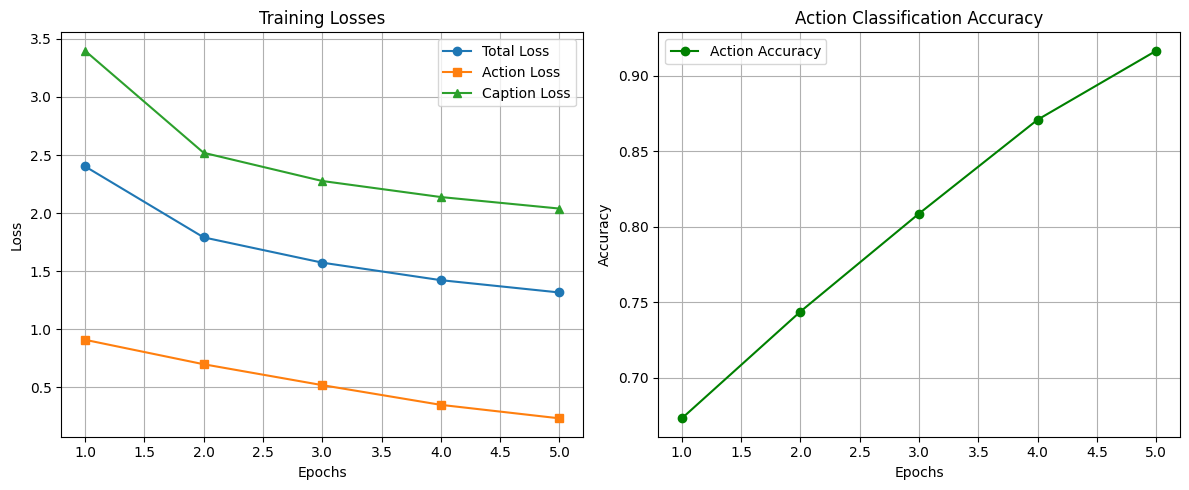

In [28]:
# Plot training metrics
import matplotlib.pyplot as plt

epochs = range(1, len(history["total_loss"]) + 1)
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(epochs, history["total_loss"], label='Total Loss', marker='o')
plt.plot(epochs, history["action_loss"], label='Action Loss', marker='s')
plt.plot(epochs, history["caption_loss"], label='Caption Loss', marker='^')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["action_acc"], label='Action Accuracy', color='green', marker='o')
plt.title('Action Classification Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
# Save model weights, vocabulary, and action labels
os.makedirs("model_artifacts", exist_ok=True)
save_path = os.path.join("model_artifacts", "multitask_cnn_lstm.pth")

# Handle DataParallel wrapping
model_to_save = model.module if hasattr(model, "module") else model

torch.save({
    "model_state_dict": model_to_save.state_dict(),
    "config": {
        "embed_dim": EMBED_DIM,
        "hidden_dim": HIDDEN_DIM,
        "num_lstm_layers": NUM_LSTM_LAYERS,
        "max_seq_len": MAX_SEQ_LEN,
        "num_actions": len(ACTION_CLASSES),
        "vocab_size": VOCAB_SIZE,
        "pad_id": vocab.pad_id,
        "sos_id": vocab.sos_id,
        "eos_id": vocab.eos_id,
        "unk_id": vocab.unk_id
    }
}, save_path)

with open(os.path.join("model_artifacts", "vocab.json"), "w", encoding="utf-8") as f:
    json.dump({
        "itos": vocab.itos,
        "stoi": vocab.stoi
    }, f)

with open(os.path.join("model_artifacts", "action_labels.json"), "w", encoding="utf-8") as f:
    json.dump(ACTION_CLASSES, f)

print("Saved:", save_path)
print("Artifacts in ./model_artifacts")

Saved: model_artifacts/multitask_cnn_lstm.pth
Artifacts in ./model_artifacts


In [30]:
# Inference: load artifacts and test on a sample image

ARTIFACT_DIR = "model_artifacts"  # On Kaggle, this is under /kaggle/working/model_artifacts
CKPT_PATH = os.path.join(ARTIFACT_DIR, "multitask_cnn_lstm.pth")
VOCAB_PATH = os.path.join(ARTIFACT_DIR, "vocab.json")
ACTIONS_PATH = os.path.join(ARTIFACT_DIR, "action_labels.json")

assert os.path.isfile(CKPT_PATH), f"Checkpoint not found at {CKPT_PATH}"
assert os.path.isfile(VOCAB_PATH), f"Vocab not found at {VOCAB_PATH}"
assert os.path.isfile(ACTIONS_PATH), f"Action labels not found at {ACTIONS_PATH}"

with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    vdata = json.load(f)
with open(ACTIONS_PATH, "r", encoding="utf-8") as f:
    action_classes = json.load(f)

# Rebuild vocab object
vocab = Vocabulary(min_freq=1)
vocab.itos = vdata["itos"]
vocab.stoi = {k: int(v) if isinstance(v, str) and v.isdigit() else v for k, v in vdata["stoi"].items()}
vocab.pad_id = vocab.stoi[vocab.pad_token]
vocab.sos_id = vocab.stoi[vocab.sos_token]
vocab.eos_id = vocab.stoi[vocab.eos_token]
vocab.unk_id = vocab.stoi[vocab.unk_token]

# Load checkpoint and rebuild model
ckpt = torch.load(CKPT_PATH, map_location=device)
conf = ckpt["config"]
model = MultiTaskModel(
    num_actions=len(action_classes),
    vocab_size=conf["vocab_size"],
    embed_dim=conf["embed_dim"],
    hidden_dim=conf["hidden_dim"],
    num_layers=conf["num_lstm_layers"],
    pad_id=conf["pad_id"],
).to(device)
model.load_state_dict(ckpt["model_state_dict"])  # type: ignore
model.eval()

# Pick a sample image from val/train/test folders
sample_dirs = [
    os.path.join(DATA_ROOT, "val2017"),
    os.path.join(DATA_ROOT, "train2017"),
    os.path.join(DATA_ROOT, "test2017"),
]
existing_dirs = [d for d in sample_dirs if os.path.isdir(d)]
assert len(existing_dirs) > 0, "No image folders found for testing."
img_dir = existing_dirs[0]
imgs = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
assert len(imgs) > 0, f"No images found in {img_dir}"
# sample_img_path = os.path.join(img_dir, random.choice(imgs))
sample_img_path = "/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000016.jpg"
print("Testing image:", sample_img_path)

# Preprocess and run model
img = Image.open(sample_img_path).convert("RGB")
img_t = transform(img).unsqueeze(0).to(device)
with torch.no_grad():
    action_logits, _ = model(img_t, torch.tensor([[vocab.sos_id]], device=device))
    action_probs = F.softmax(action_logits, dim=-1).squeeze(0).cpu()

# Top-5 actions
topk = torch.topk(action_probs, k=min(5, len(action_classes)))
print("Top action predictions:")
for p, i in zip(topk.values.tolist(), topk.indices.tolist()):
    print(f"  {action_classes[i]}: {p:.3f}")

# Greedy caption generation
def generate_caption(model, img_t, vocab, max_len):
    with torch.no_grad():
        img_feat = model.cnn(img_t)
        h0 = torch.tanh(model.caption_head.to_h0(img_feat))
        c0 = torch.tanh(model.caption_head.to_c0(img_feat))
        h = h0.unsqueeze(0).repeat(model.caption_head.num_layers, 1, 1)
        c = c0.unsqueeze(0).repeat(model.caption_head.num_layers, 1, 1)
        cur = torch.tensor([[vocab.sos_id]], device=img_t.device)
        out_tokens = []
        for _ in range(max_len):
            emb = model.caption_head.embed(cur)
            y, (h, c) = model.caption_head.lstm(emb, (h, c))
            logits = model.caption_head.out(y[:, -1, :])
            nxt = torch.argmax(logits, dim=-1).item()
            if nxt == vocab.eos_id:
                break
            out_tokens.append(nxt)
            cur = torch.tensor([[nxt]], device=img_t.device)
        words = [vocab.itos[i] if i < len(vocab.itos) else "<UNK>" for i in out_tokens]
        return " ".join(words)

caption = generate_caption(model, img_t, vocab, max_len=conf.get("max_seq_len", 20))
print("Generated caption:", caption)

Testing image: /kaggle/input/coco-2017-dataset/coco2017/test2017/000000000016.jpg
Top action predictions:
  playing: 0.515
  standing: 0.476
  running: 0.007
  walking: 0.002
  sitting: 0.000
Generated caption: a baseball player holding a bat while standing on a field
